<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CGANCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
COLOURISATION_EPOCHS = 1000
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 10

# Import Statements

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Load Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

170500096/170498071 [==============================] - 2s 0us/step


# Convert Classification Images to Grayscale

In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

# Load the Classification Model

In [5]:
model_dir = os.path.dirname(base_dir + "classification.h5")

json_file = open(base_dir + "classification.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
classification_model = models.model_from_json(loaded_model_json)
classification_model.load_weights(base_dir + "classification.h5", by_name=False)

opt = optimizers.SGD(lr=0.001, momentum=0.9)
classification_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

print("Loaded model from disk")

Loaded model from disk


# Classification Results

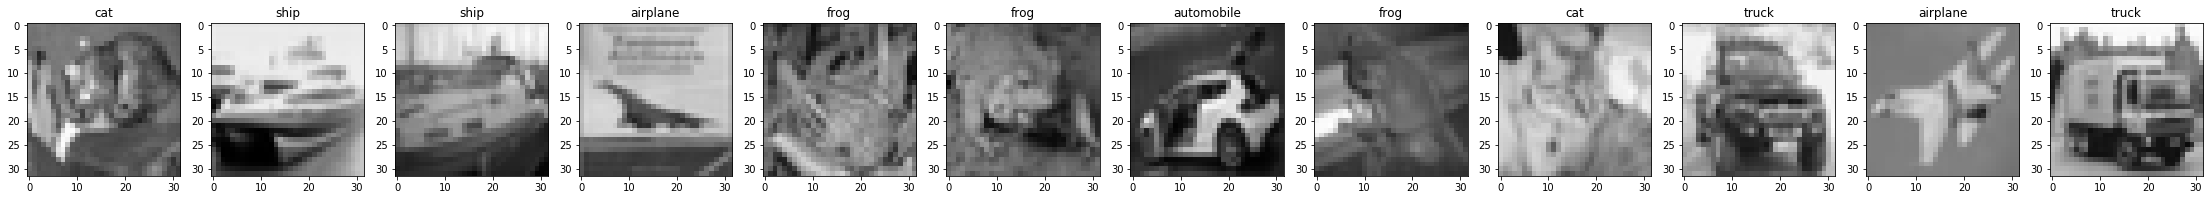

In [6]:
image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

output_count = 12

fig = plt.figure(figsize=(39,39))
for i in range(output_count):
  result = classification_model.predict_classes(tf.expand_dims(test_gray_images[i], 0))
  fig.add_subplot(1,output_count,i+1)
  plt.title(image_labels[int(result)])
  plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[i]))

# Evaluate Image Class

Predicted image class: [0] - airplane


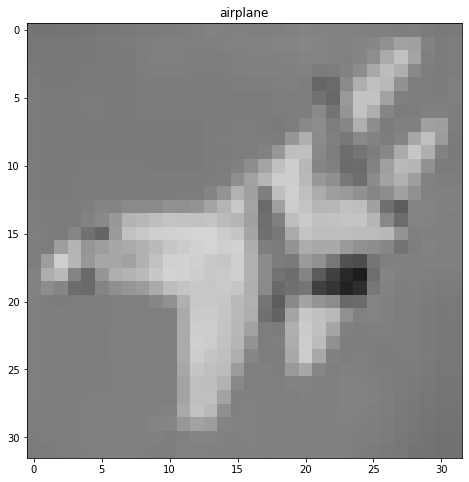

In [7]:
result = classification_model.predict_classes(tf.expand_dims(test_gray_images[INPUT_IMAGE], 0))
print("Predicted image class:", result, "-", image_labels[int(result)])
fig = plt.figure(figsize=(8,8))
plt.title(image_labels[int(result)])
plt.imshow(tf.image.grayscale_to_rgb(test_gray_images[INPUT_IMAGE]))

class_train_indices = np.argwhere(train_labels == result)
class_train_images = train_images[class_train_indices[:,0]]
class_test_indices = np.argwhere(test_labels == result)
class_test_images = test_images[class_test_indices[:,0]]

# Convert Colourisation Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(class_train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(class_test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Batch the dataset
# train_y = tf.data.Dataset.from_tensor_slices(train_y).batch(BATCH_SIZE)
# train_uv = tf.data.Dataset.from_tensor_slices(train_uv).batch(BATCH_SIZE)
# test_y = tf.data.Dataset.from_tensor_slices(test_y).batch(BATCH_SIZE)
# test_uv = tf.data.Dataset.from_tensor_slices(test_uv).batch(BATCH_SIZE)

# Split the dataset into batches
batched_train_y = np.array(np.split(train_y, (train_y.shape[0]/BATCH_SIZE)))
batched_train_uv = np.array(np.split(train_uv, (train_uv.shape[0]/BATCH_SIZE)))

# Create the Generator Network

In [9]:
def create_colourisation_generator():
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), bias_regularizer=regularizers.l1(0.00001), input_shape=(32, 32, 1)))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same', strides=2))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(16, (3, 3), bias_regularizer=regularizers.l1(0.00001), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.05))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(2, (3, 3), activation='tanh', bias_regularizer=regularizers.l1(0.00001), padding='same'))
    opt = optimizers.RMSprop(lr=0.0001, momentum=0.0)
    model.compile(optimizer=opt, loss='mse')
    return model

create_colourisation_generator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         80        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 16)        1168      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)          0

# Create the Discriminator Network

In [10]:
def create_colourisation_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 2]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

create_colourisation_discriminator().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        3264      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

# Define Loss Function and Optimiser

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Train the Colourisation Model

In [31]:
generator = create_colourisation_generator()
discriminator = create_colourisation_discriminator()

generator.summary()
discriminator.summary()

num_examples_to_generate = 16

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(train_y, train_uv):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_uv = generator(train_y, training=True)

      real_output = discriminator(train_uv, training=True)
      fake_output = discriminator(generated_uv, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(train_y, train_uv, epochs):
  for epoch in range(epochs):
    start = time.time()

    for i in range(batched_train_y.shape[0]):
      train_step(batched_train_y[i], batched_train_uv[i])

    # Produce images for the GIF as we go
    # display.clear_output(wait=True)
    # generate_and_save_images(generator, epoch + 1, seed)

    # # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator, epochs, seed)
  
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

train(train_y, train_uv, COLOURISATION_EPOCHS)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 15, 15, 16)        1168      
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 8, 8, 32)          4640      
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 8, 8, 32)        

KeyboardInterrupt: ignored

# Training Results

5000/5000 [==============================] - 1s 162us/sample - loss: 0.0046
0.0045593850258737805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


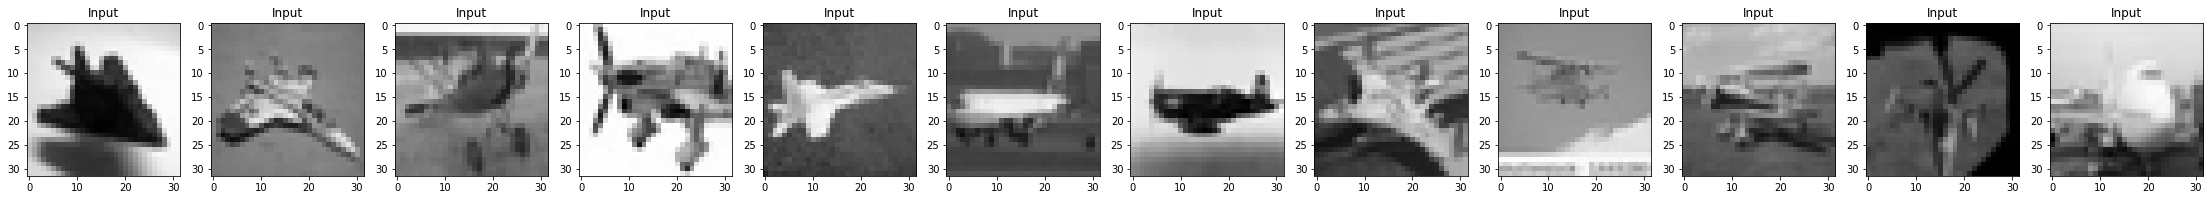

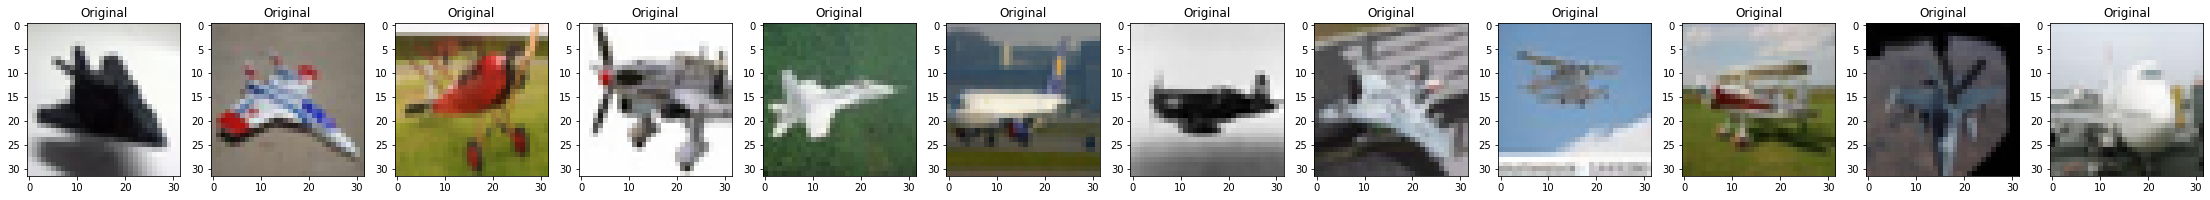

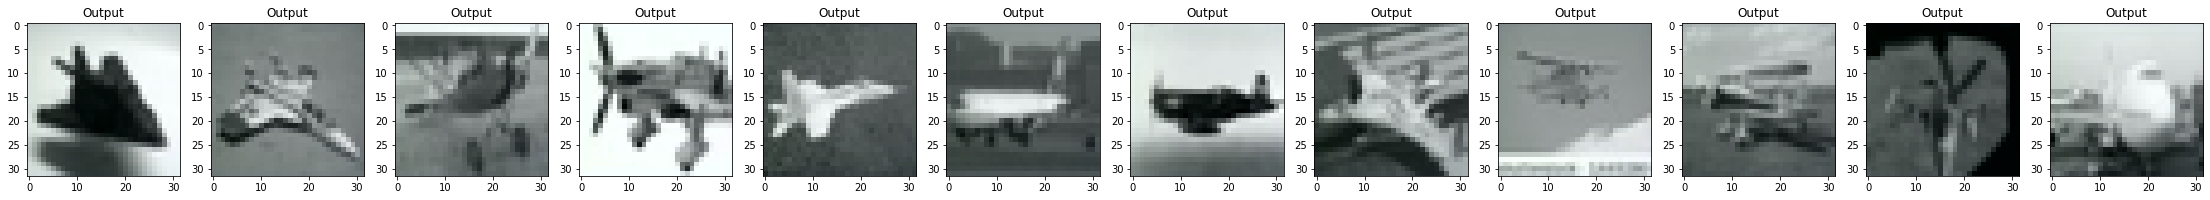

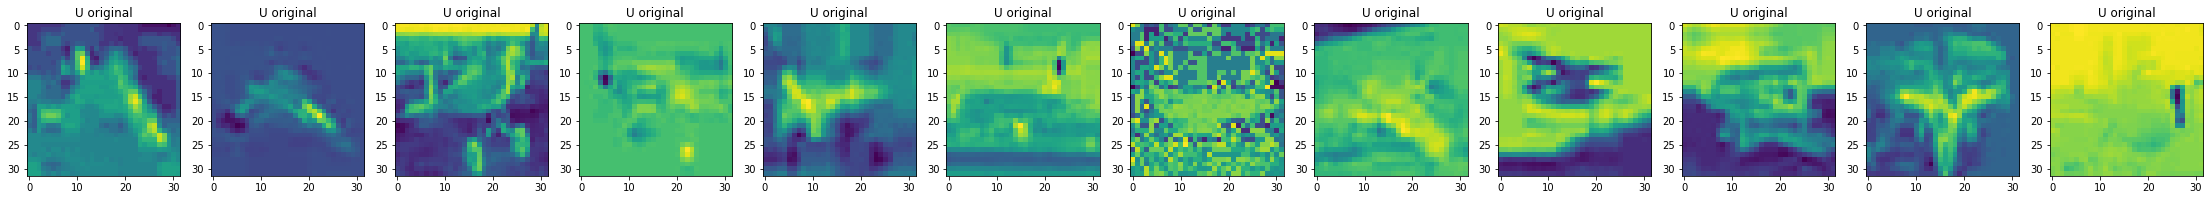

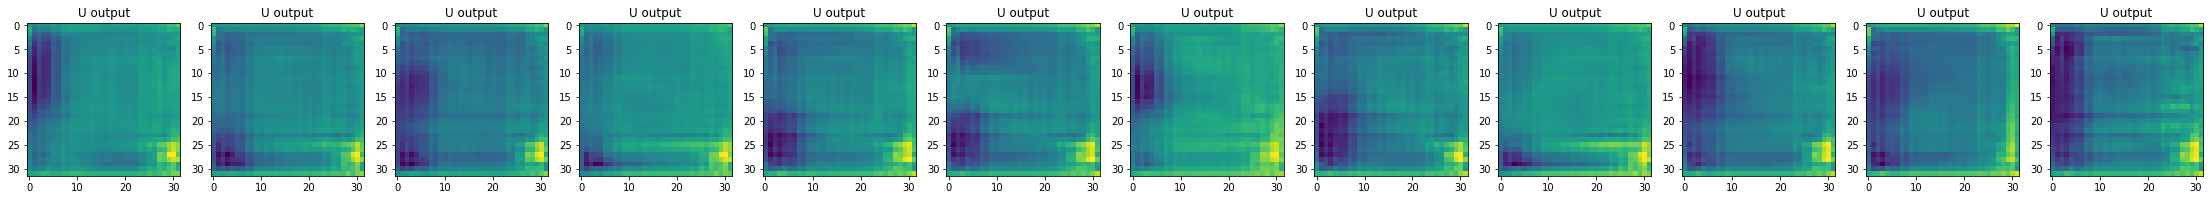

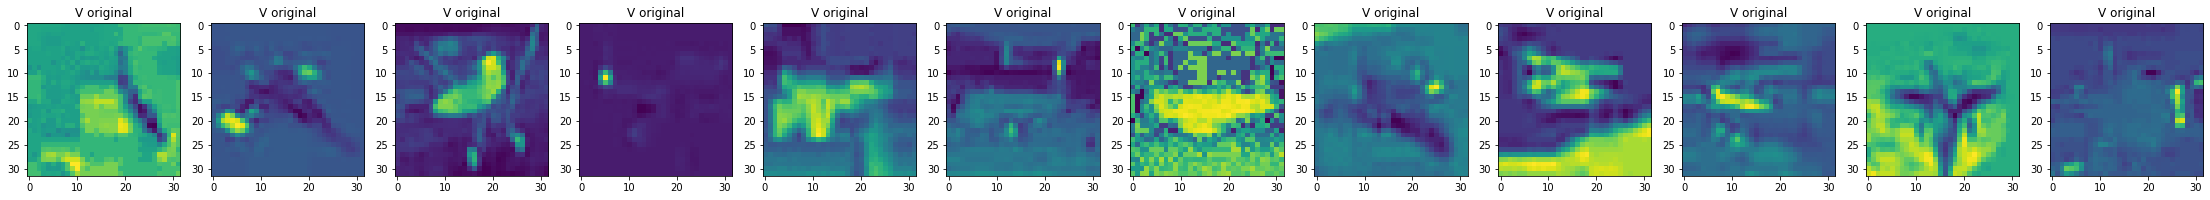

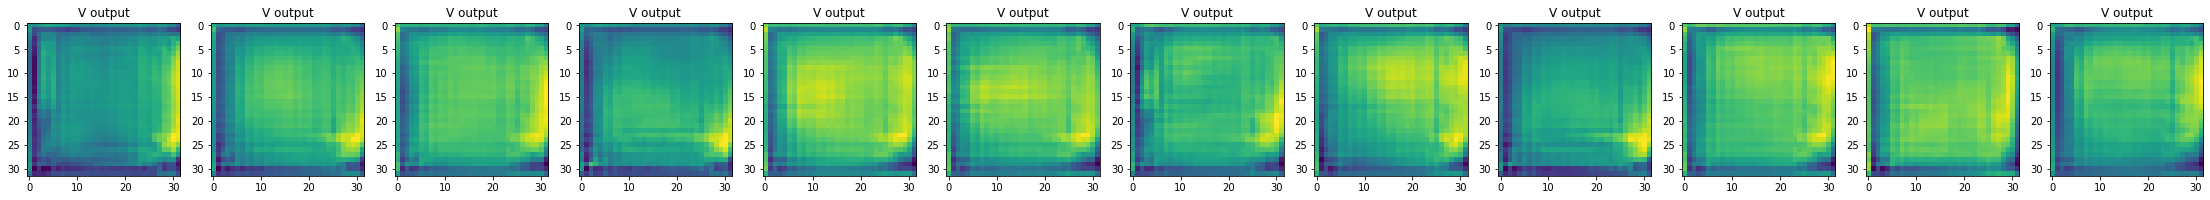

In [34]:
print(generator.evaluate(train_y, train_uv))
output = generator.predict(train_y)
result = np.zeros((train_y.shape[0], 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(class_train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])